In [ ]:
#importing libraries

import pandas as pd
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import os
from google.colab import files
import requests
import tarfile
from io import BytesIO
from typing import Optional, Tuple
import sklearn.datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import Lasso, Ridge
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

import random
random.seed(123)

from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import re
import time


# Task 1: Data Processing

**Task 1.1: Load and pre-process IMDB Reviews Data**

Downloading Movie Review Text

In [ ]:
def fetch_imdb_reviews(download_dir: str):
    """Fetch IMDB Movie Review data and save it to :download_dir:"""

    response = requests.get('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')

    # Check if the request was successful (status code 200) and extract the contents to :donwload_dir:
    if response.status_code == 200:

        tar_file = tarfile.open(fileobj=BytesIO(response.content), mode="r:gz")
        tar_file.extractall(path=download_dir)

        tar_file.close()

        print("Extraction completed.")
    else:
        print(f"Failed to download the tar file. Status code: {response.status_code}")


In [ ]:
download_dir = './'

fetch_imdb_reviews(download_dir)  # if successful, you should see a new folder called aclImdb in :download_dir:

Extraction completed.


Filter Features - BoW .feat Files  
- Working on dealing with the BoW .feat files and accessing the data contained in them

In [ ]:
def find_rare_stopwords(aclImdb_dir: str):
    vocab_file_path = os.path.join(aclImdb_dir, 'imdb.vocab')
    with open(vocab_file_path, 'r', encoding='utf-8') as file:
        words = file.readlines()
        words = [word.strip() for word in words]

    bow_file_path = os.path.join(aclImdb_dir, 'train/labeledBow.feat')
    with open(bow_file_path, 'r', encoding='utf-8') as file:
        features_rates = file.readlines()
        features_rates = [line.strip() for line in features_rates]
        num_features = len(words)
        num_data = len(features_rates)
        featues_repeatance = np.zeros((num_features))
        for i in range(len(features_rates)):
            pairs = re.findall(r'(\d+:\d+)', features_rates[i])
            pairs_list = [tuple(map(int, pair.split(':'))) for pair in pairs]
            for j in range(len(pairs_list)):
                featues_repeatance[pairs_list[j][0]] += 1

        featues_repeatance /= num_data

        # checking for rare words and stoppped words (<1% and >50%)
        selected_inds = np.where((featues_repeatance <= 0.5) & (featues_repeatance >= 0.01))
        selected_words =  np.array(words)[selected_inds[0]]
    return selected_inds[0], selected_words

polarized_words, polarized_words_str = find_rare_stopwords('./aclImdb')
print(len(polarized_words))
print(len(polarized_words_str))

1744
1744


In [ ]:
def features_generator(aclImdb_dir: str, train_test):
    vocab_file_path = os.path.join(aclImdb_dir, 'imdb.vocab')
    with open(vocab_file_path, 'r', encoding='utf-8') as file:
        words = file.readlines()
        words = [word.strip() for word in words]
    if train_test == 'train':
        bow_file_path = os.path.join(aclImdb_dir, 'train/labeledBow.feat')
    else:
        bow_file_path = os.path.join(aclImdb_dir, 'test/labeledBow.feat')

    with open(bow_file_path, 'r', encoding='utf-8') as file:
        features_rates = file.readlines()
        features_rates = [line.strip() for line in features_rates]

    polarized_words, polarized_words_str = find_rare_stopwords(aclImdb_dir)
    # print(polarized_words.shape)
    polarized_words_dict = {index: value for index, value in enumerate(polarized_words)}
    polarized_words_inverted_dict = dict(map(reversed, polarized_words_dict.items()))
    num_features = len(polarized_words)
    num_data = len(features_rates)
    features_values =  np.zeros((num_data, num_features))
    ratings_vector  = np.zeros((num_data))
    for i in range(len(features_rates)):
        pairs = re.findall(r'(\d+:\d+)', features_rates[i])
        for pair in pairs:
            tup = tuple(map(int, pair.split(':')))
            if tup[0] in polarized_words_dict.values():
                features_values[i,polarized_words_inverted_dict[tup[0]]] = tup[1]
                ratings_vector[i] = features_rates[i][0]
    return features_values, ratings_vector, polarized_words_str

x, y, polarized_words_str = features_generator('./aclImdb', 'train')
print(polarized_words_str)

['he' 'his' '!' ... 'opens' 'essentially' 'received']


In [ ]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]                         #add a dimension for the features
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])    #add bias by adding a constant feature of value 1
        #alternatively: self.w = np.linalg.inv(x.T @ x)@x.T@y
        self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference
        return self

    def predict(self, x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w                             #predict the y values
        return yh


In [ ]:
def standardization(x, test = False, train_mean = None, train_std = None):
    if test:
      # Standardize the test feature matrix with mean and std of train
      x_standardized = (x - train_mean) / train_std

    # Standardize the feature matrix
    x_standardized = (x - x.mean(axis=0)) / x.std(axis=0)
    return x_standardized

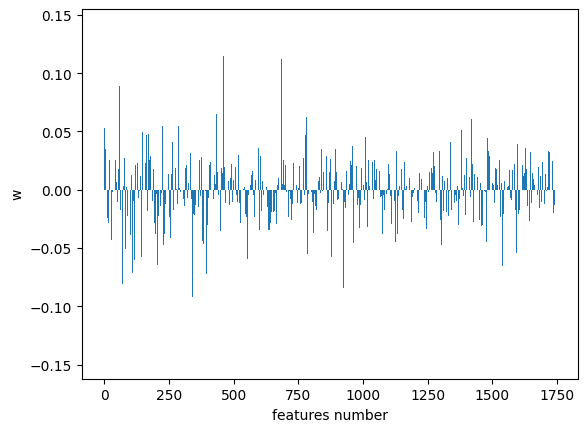

[-0.05820662  0.05325801 -0.09668227 ...  0.01302959 -0.02337913
  3.7742    ]


In [ ]:
# Applying linear regression on the training data to find important features
x_training, y_training, polarized_words_str = features_generator('./aclImdb', 'train')
num_features = x_training.shape[1]
x_standardized_training = standardization(x_training)
model_linear = LinearRegression()
yh = model_linear.fit(x_standardized_training,y_training).predict(x_standardized_training)
plt.bar(np.arange(num_features), model_linear.w[:-1])
plt.xlabel('features number')
plt.ylabel('w')
plt.show()
print(model_linear.w)

Printing the result in a tabular format for 10 important featurs overall
     String              |              Number     
---------------------------------------------------
      bad                |          -0.14764036167376354
      fun                |          0.14051545952426342
     good                |          0.13602031048533547
     waste               |          -0.1238960277517756
     worst               |          -0.12014350063124399
    enjoyed              |          0.11514356276501186
     liked               |          0.11394600790617399
   enjoyable             |          0.11224975974079435
     great               |          0.10812952528542158
     worth               |          0.1005638946320224
Printing the result in a tabular format for 10 positively important featurs
---------------------------------------------------
      fun                |          0.14051545952426342
     good                |          0.13602031048533547
    enjoyed           

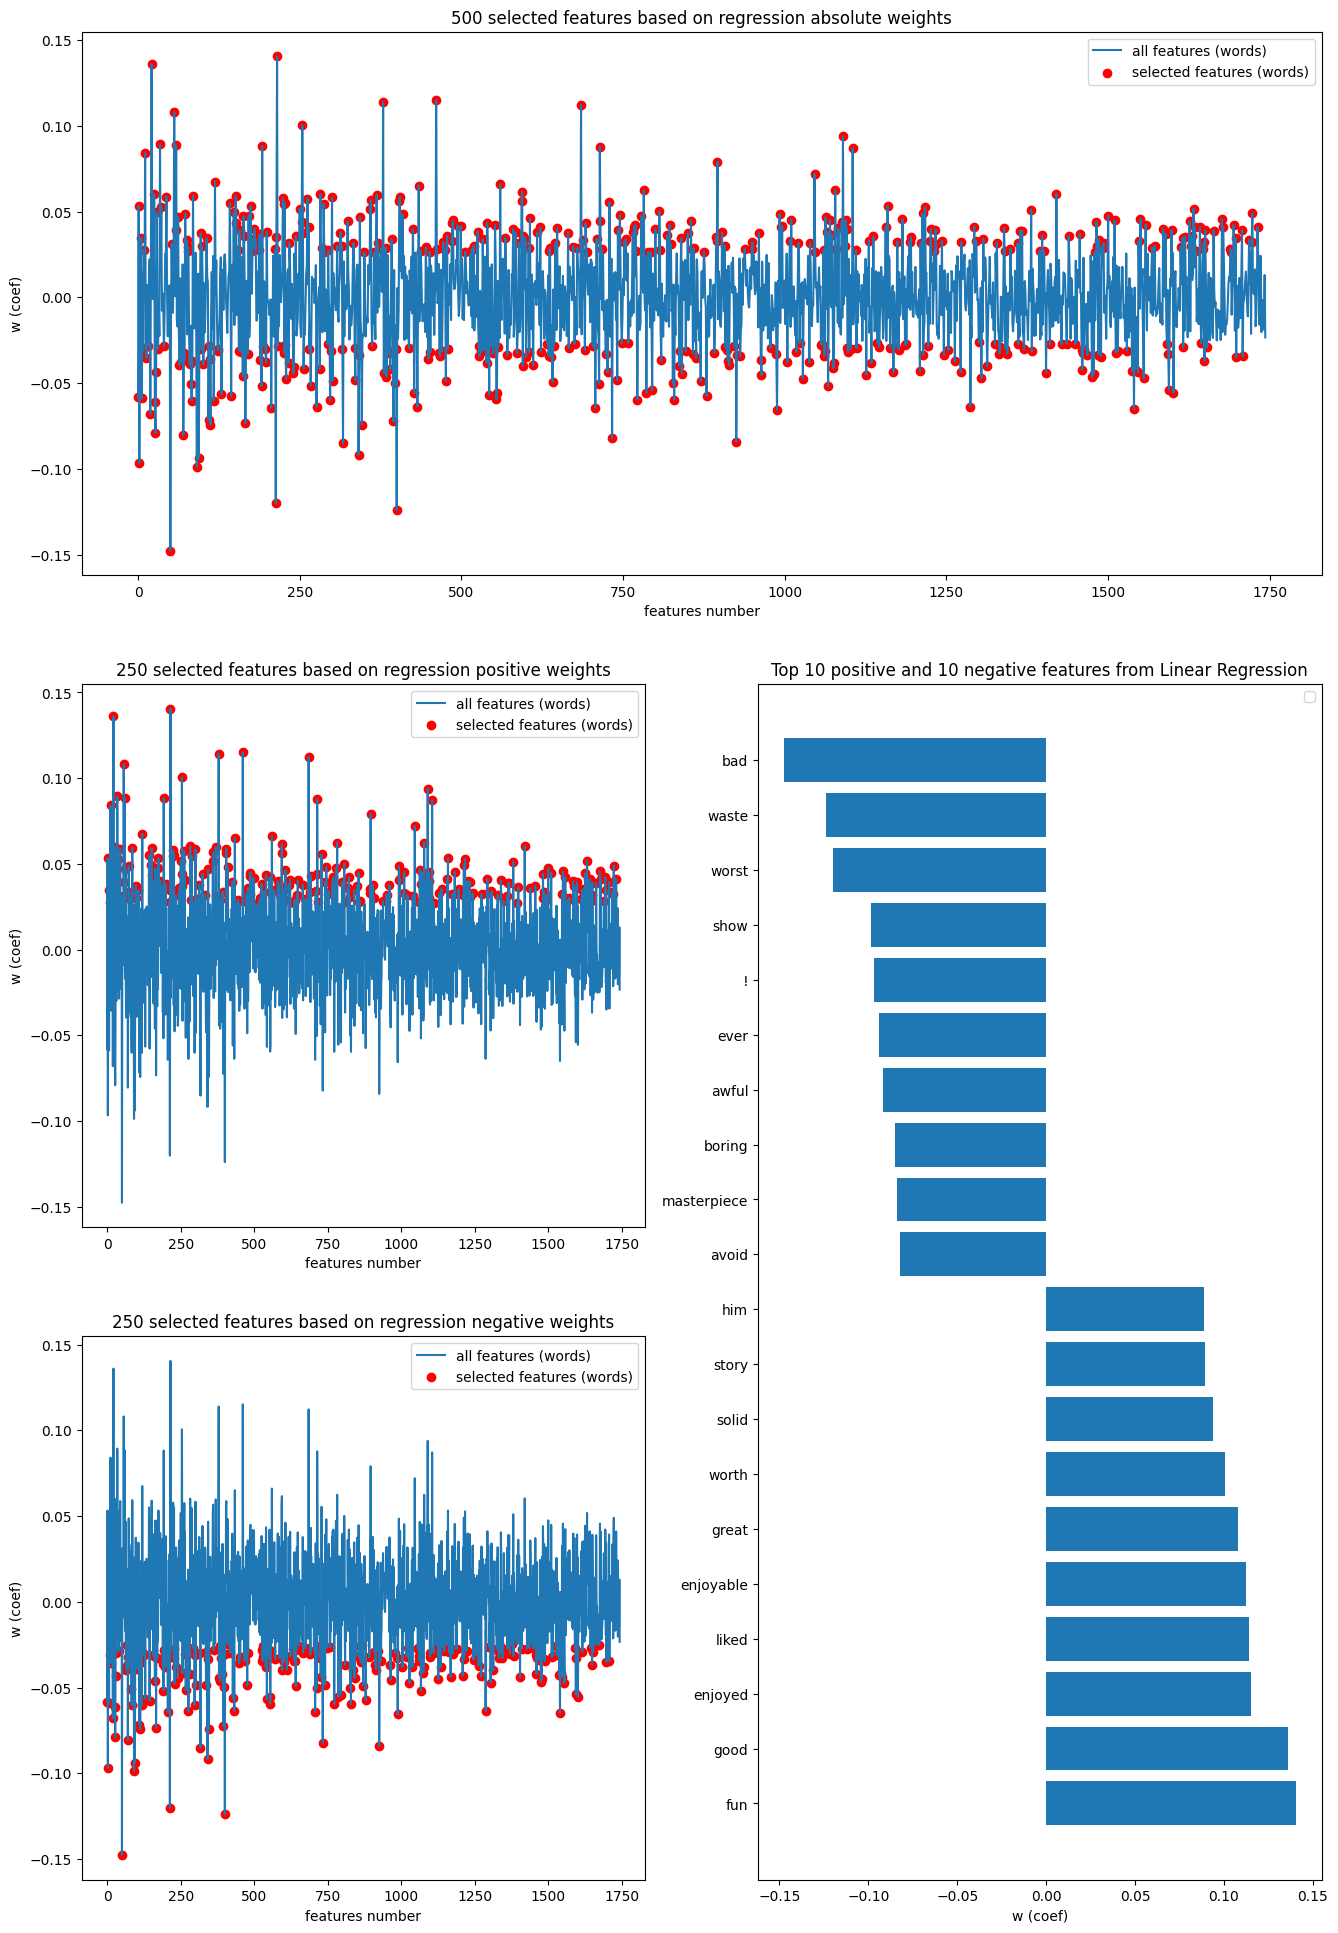

In [ ]:
num_features_vec = np.arange(num_features)
weights_vec = model_linear.w[:-1]
# Get the indices that would sort the data in descending order
sorted_indices = np.argsort(abs(weights_vec))[::-1]       # Sorting indices based on the abs values of weights
sorted_indices_pos = np.argsort(weights_vec)[::-1]        # Sorting indices based on the values of weights (to collect highest positive ones)
sorted_indices_neg = np.argsort(weights_vec)              # Sorting indices based on the negative values of weights (to collect highest negative ones)

# Collect  the 500 highest abs weights
sorted_num_features_vec = num_features_vec[sorted_indices]
selected_features = sorted_num_features_vec[:500]
sorted_weights_vec = weights_vec[sorted_indices]
selected_weights = sorted_weights_vec[:500]

# Collect  the 500 highest pos weights
sorted_num_features_vec_pos = num_features_vec[sorted_indices_pos]
selected_features_pos = sorted_num_features_vec_pos[:250]
sorted_weights_vec_pos = weights_vec[sorted_indices_pos]
selected_weights_pos = sorted_weights_vec_pos[:250]

# Collect  the 500 highest neg weights
sorted_num_features_vec_neg = num_features_vec[sorted_indices_neg]
selected_features_neg = sorted_num_features_vec_neg[:250]
sorted_weights_vec_neg = weights_vec[sorted_indices_neg]
selected_weights_neg = sorted_weights_vec_neg[:250]

plt.figure(figsize=(16, 24))
plt.subplot(3,2,(1,2))
# Plot the selected features based on regression abs weights
plt.plot(num_features_vec, weights_vec, label = 'all features (words)')
plt.scatter(selected_features, selected_weights, color='r', label = 'selected features (words)')
plt.xlabel('features number')
plt.ylabel('w (coef)')
plt.title('500 selected features based on regression absolute weights')
plt.legend()


# Printing the result in a tabular format for 10 important featurs overall
print('Printing the result in a tabular format for 10 important featurs overall')
print("     String              |              Number     ")
print("---------------------------------------------------")
for row in list(zip(polarized_words_str[selected_features[:10]],selected_weights[:10])):
    print(f"{row[0]:^15}          |          {row[1]:^15}")

plt.subplot(3,2,3)
# Plot the selected features based on regression high positive weights
plt.plot(num_features_vec, weights_vec, label = 'all features (words)')
plt.scatter(selected_features_pos, selected_weights_pos,color='r', label = 'selected features (words)')
plt.xlabel('features number')
plt.ylabel('w (coef)')
plt.title('250 selected features based on regression positive weights')
plt.legend()

# Printing the result in a tabular format for 10 positively important featurs
print('Printing the result in a tabular format for 10 positively important featurs')
print("---------------------------------------------------")
for row in list(zip(polarized_words_str[selected_features_pos[:10]],selected_weights_pos[:10])):
    print(f"{row[0]:^15}          |          {row[1]:^15}")

plt.subplot(3,2,5)
# Plot the selected features based on regression high negative weights
plt.plot(num_features_vec, weights_vec, label = 'all features (words)')
plt.scatter(selected_features_neg, selected_weights_neg,color='r', label = 'selected features (words)')
plt.title('250 selected features based on regression negative weights')
plt.xlabel('features number')
plt.ylabel('w (coef)')
plt.legend()


# Printing the result in a tabular format for 10 negatively important featurs
print('Printing the result in a tabular format for 10 negatively important featurs')
print("---------------------------------------------------")
for row in list(zip(polarized_words_str[selected_features_neg[:10]],selected_weights_neg[:10])):
    print(f"{row[0]:^15}          |          {row[1]:^15}")

plt.subplot(3,2,(4,6))
# Plot top pos and neg weights in a bar plot
topweights = np.concatenate([selected_weights_pos[:10],selected_weights_neg[:10]])
topfeatures = np.concatenate([polarized_words_str[selected_features_pos[:10]],polarized_words_str[selected_features_neg[:10]]])
indices = np.argsort(topweights)[::-1]
sorted_topfeatures = topfeatures[indices]
sorted_topweights = topweights[indices]
plt.barh(sorted_topfeatures, sorted_topweights)
plt.title('Top 10 positive and 10 negative features from Linear Regression')
plt.xlabel('w (coef)')
plt.legend()
# plt.savefig(f'imdb_features_pos-neg20.png', bbox_inches='tight')
plt.show()
# files.download(f'imdb_features_pos-neg20.png')

# **Task 1.2: 20-news group dataset**

1.2.1: Converting text to feature vectors
NOTES ABOUT DATA SET:
* Category = name of newsgroup = name of folder holding the individual documents

In [ ]:
categories = ["misc.forsale", "rec.sport.hockey", "sci.med", "sci.space", "talk.politics.guns"] # Choose 5 arbitrary categories to work with
news_train = sklearn.datasets.fetch_20newsgroups(subset="train", shuffle=True, random_state=42, categories = categories, remove=(["headers", "footers", "quotes"]))

### EXAMPLE: Printing the line below prints out the first file from rec.sport.hockey
#print(news_train.data[0])


### Use Bag of Words model to extract features from text files ##
### Step 1: Build dictionary with a word contained in any document of the training set and an assigned integer id
cv_stop = CountVectorizer(max_df=0.5, min_df=0.01) # Filters out words in less than 1%, more than 50% of documents
X_train_counts_stop = cv_stop.fit_transform(news_train.data)
X_train_vocab = cv_stop.vocabulary_



### If you want to see the words that were filtered out
#print(cv_stop.stop_words_)


### Returns the count for the provided word:
#print(cv_stop.vocabulary_.get('hockey'))

### Tuple of form (# documents, # unique words in dictionary)
print(X_train_counts_stop.shape)

### WHOLE DICTIONARY:
### Tuple of form (document index, word index) then the frequency of the word - similar to labelled BoW files
#print(X_train_counts_stop)

(2918, 1520)


1.2.2: Filter features
* It is discrete data (so you cannot use simple regression to externally select features)
* Use something like Mutual Information(MI) to select the top M ∈ [10, 100] feature words per class and take the union of all top feature words to train your multiclass model


**NOTE: MI is the average of PMI for all possible values**

NOTE: Might be slow with our custom implementation. Without regularization you may want to keep the number of features fairly low. For instance, with 100 feature words per class, we can still have up to 500 features in total for 5 categories

In [ ]:
def calculate_top_news_features(X_data, true_labels, X_data_vocab):
  '''Calculating the MI scores:'''

  all_feature_words = {}
  top_feature_words = []
  class_dict = {}

  heatmap_scores = {}
  repeat = 0



  num_classes = len(set(true_labels))
  mi_scores = np.zeros((X_data.shape[1], num_classes))

  for label in range(num_classes):
    mi_scores_one_label = {}
    # Create binary array indicating whether each document belongs to the current class
    class_indicator = (true_labels == label)

    for word, word_index in X_train_vocab.items():
      feature_name = word
      word_column = X_data[:, word_index]

      # Calculate mutual information score
      mi_score = mutual_info_score(class_indicator, word_column.toarray().flatten())
      mi_scores_one_label[feature_name] = mi_score


    ## Getting the top features:
    top_words = sorted(mi_scores_one_label.items(), key=lambda k: k[1], reverse=True)[:80] #adjust this to adjust feature selection size
    class_dict[label] = top_words

    heatmap_scores[label] = top_words[:5]
    all_feature_words[label] = mi_scores_one_label
    #print(label, top_words)

    # Union top words for each class
    for word in top_words:
      if word[0] not in top_feature_words:
        top_feature_words.append(word[0])
      else:
        repeat += 1


  ## Creating a matrix of which top features are in which documents:
  news_feature_matrix = np.zeros((X_data.shape[0], len(top_feature_words))) ## 2D matrix where each row is a document and each column is a feature word, 1 if word is in doc, else 0
  for i in range(len(news_train.data)): # each document
    word_arr = np.zeros(len(top_feature_words))
    for w in range(len(top_feature_words) -1): # check whether the feature word is in the document: news_train.data[i]
      if top_feature_words[w] in news_train.data[i]:
        word_arr[w] = 1.
    news_feature_matrix[i] = word_arr

  print("Number of repeated words: ", repeat)
  print(top_feature_words)
  print(heatmap_scores)
  print(all_feature_words)
  return top_feature_words, news_feature_matrix, heatmap_scores, all_feature_words


In [ ]:
## FILTERED X AND Y LABELS FOR 20 NEWSGROUP DATASET:
x_news_words, x_news_matrix, heatmap_scores, all_feature_words = calculate_top_news_features(X_train_counts_stop, news_train.target, X_train_vocab)

# Turning y_labels into a 2D matrix that states what class each document is apart of. Rows = documents, columns = classes with a 1 denoting which class the document belongs to
y_news_matrix = np.zeros((len(news_train.target), len(set(news_train.target))))

for i in range(len(news_train.target)):
  c = news_train.target[i]
  y_news_matrix[i][c] = 1

Number of repeated words:  76
['sale', 'shipping', 'offer', 'condition', 'sell', 'price', 'was', 'be', 'asking', 'they', 'please', 'there', 'manuals', 'what', 'interested', 'brand', 'email', 'he', 'were', 'card', 'as', 'their', 'manual', 'on', 'about', 'but', 'mail', 'drive', 'obo', '00', 'think', 'not', 'ram', 'do', 'when', 'this', 'his', 'stereo', 'people', 'monitor', 'would', 'offers', 'new', 'includes', 'we', 'software', 'how', 'from', 'controller', 'team', 'had', 'keyboard', 'see', 'disk', 'could', 'being', 'windows', 'floppy', 'who', 'should', 'dos', 'disks', 'might', 'excellent', 'even', 'computer', 'because', 'did', 'modem', 'original', 'pc', 'selling', 'say', 'package', 'items', '25', 'why', 'are', 'cd', 'which', 'hockey', 'game', 'nhl', 'season', 'play', 'players', 'league', 'playoffs', 'teams', 'rangers', 'playoff', 'games', 'cup', 'win', 'leafs', 'player', 'pittsburgh', 'played', 'coach', 'islanders', 'ice', 'detroit', 'montreal', 'goals', 'devils', 'playing', 'toronto', 'b

In [ ]:
print(x_news_words)

['sale', 'shipping', 'offer', 'condition', 'sell', 'price', 'was', 'be', 'asking', 'they', 'please', 'there', 'manuals', 'what', 'interested', 'brand', 'email', 'he', 'were', 'card', 'as', 'their', 'manual', 'on', 'about', 'but', 'mail', 'drive', 'obo', '00', 'think', 'not', 'ram', 'do', 'when', 'this', 'his', 'stereo', 'people', 'monitor', 'would', 'offers', 'new', 'includes', 'we', 'software', 'how', 'from', 'controller', 'team', 'had', 'keyboard', 'see', 'disk', 'could', 'being', 'windows', 'floppy', 'who', 'should', 'dos', 'disks', 'might', 'excellent', 'even', 'computer', 'because', 'did', 'modem', 'original', 'pc', 'selling', 'say', 'package', 'items', '25', 'why', 'are', 'cd', 'which', 'hockey', 'game', 'nhl', 'season', 'play', 'players', 'league', 'playoffs', 'teams', 'rangers', 'playoff', 'games', 'cup', 'win', 'leafs', 'player', 'pittsburgh', 'played', 'coach', 'islanders', 'ice', 'detroit', 'montreal', 'goals', 'devils', 'playing', 'toronto', 'bruins', 'scoring', 'quebec', '

In [ ]:
def multiclass_class_distribution(y_matrix):
  distribution = {"misc.forsale":0, "rec.sport.hockey":0, "sci.med":0, "sci.space":0, "talk.politics.guns":0}

  for y in y_matrix:
    if y[0] == 1:
      distribution["misc.forsale"]+= 1
    elif y[1] == 1:
      distribution["rec.sport.hockey"] +=1
    elif y[2] == 1:
      distribution["sci.med"] +=1
    elif y[3] == 1:
      distribution["sci.space"] +=1
    elif y[4] == 1:
      distribution["talk.politics.guns"] +=1

  for target in distribution:
    distribution[target] = distribution[target]/len(y_matrix)

  return distribution

distribution = multiclass_class_distribution(y_news_matrix)
for element in distribution:
  print(str(element) + ':' + str(distribution[element]))

misc.forsale:0.20047978067169295
rec.sport.hockey:0.20562028786840303
sci.med:0.20356408498971898
sci.space:0.20322138450993832
talk.politics.guns:0.18711446196024675


# Task 2: Model Implementation

## Logistic regression class
Now we are ready to implement the logistic regression class with the usual `fit` and `predict` methods. Here, the `fit` method implements gradient descent.

Implement and evaluate Logistic Regression on the IMDB data.

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function
class LogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N       # divide by N because cost is mean over N points
        return grad

    def fit(self, x, y, x_valid=None, y_valid=None):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        if x_valid is not None and y_valid is not None:
            if x_valid.ndim == 1:
                x_valid = x_valid[:, None]
            if self.add_bias:
                N_v = x_valid.shape[0]
                x_valid = np.column_stack([x_valid,np.ones(N_v)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        losses_valid = []
        losses_train = []
        # grad_norm_train = []
        self.Weights = []
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g
            loss_train = self.ce(x, y)                                    # Store the CEs
            losses_train.append(loss_train)
            if x_valid is not None and y_valid is not None:
                loss_valid = self.ce(x_valid, y_valid)
                losses_valid.append(loss_valid)
            # grad_norm_train.append(np.linalg.norm(g))
            self.Weights.append(self.w)
            t += 1

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return losses_train, losses_valid


    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias and np.all(x[:, -1]!= np.ones(Nt)) :
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output probabilities
        y_pred =  (yh>0.5).astype(int)             #predict output
        # print(yh,y_pred)
        return yh, y_pred

    def ce(self, x, y):
        # print(self.w)
        N = x.shape[0]
        return np.sum(y * np.log1p(np.exp(-np.dot(x, self.w))) + (1-y) * np.log1p(np.exp(np.dot(x, self.w))))/N


    def check_grad(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])

        N,D = x.shape
        diff = np.zeros((D))
        w = self.w.copy()
        w_rand = np.random.rand(D) ##

        for i in range(D):
            epsilon = np.zeros((D))
            epsilon[i] = np.random.rand() * 1e-4

            self.w = w_rand ##

            self.w = self.w + epsilon
            J1 = self.ce(x, y)
            self.w = w_rand ##

            self.w = self.w - epsilon
            J2 = self.ce(x, y)
            self.w = w_rand ##

            numeric_grad = (J1 - J2) / (2 * epsilon[i])
            derived_grad = self.gradient(x, y)[i]
            # print(J1,J2,(J1 - J2))
            diff[i] = np.square(derived_grad - numeric_grad).sum()/np.square(derived_grad + numeric_grad).sum()
        # print(diff)
        # print(sum(diff>=diff.sum()), diff.min(),diff.mean(), diff.max() )
        self.w = w ##
        return diff.sum()

def evaluate_acc(y_test, y_pred):
    accuracy = np.sum(y_pred == y_test)/len(y_test)
    return accuracy

For binary classification of IMDB data set, you should use Receiver Operating Characteristic (ROC) curve and area under the ROC curve (AUROC) to evaluate the model classification

Binary:
1 = positive (rating score >= 7)
0 = negative (rating score <= 4)


**See Experiment #3 for further details and graphs**


## Multiclass Regression Classifier
Define `fit` and `predict` methods within the class.

Implementing and evaluate the Multiclass Regression on the 5-class prediction from the 20-news-group data

In [ ]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
      epsilon = 1e-10
      return -np.sum(y * np.log(self.predict(X)+epsilon))

    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100,stop_early=True):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
            if stop_early == True:
                if i>0 and losses_valid[i]> losses_valid[i-1]:
                    break

                #print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
           # else:
                #print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()
        #w_rand = np.random.rand(D, C) ##

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4


                #self.W = w_rand ##

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W
                #self.W = w_rand ##


                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W
                #self.W = w_rand ##


                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             (np.square(derived_grad + numeric_grad).sum() + 1e-10)


        # for q in diff:
        #   print(q)
        self.W = W
        return diff.sum()

Split 20 Newsgroup Data into training, validation and testing

In [ ]:
# Split into train/test data
X_train_news, X_test_news, y_train_news, y_test_news = train_test_split(x_news_matrix, y_news_matrix, test_size = 0.33, random_state=42, shuffle=True)

# Split the training data further into validation data
X_train_news, X_valid_news, y_train_news, y_valid_news = train_test_split(X_train_news, y_train_news, test_size = 0.5, random_state=42, shuffle=True)


## Standardize the X data
# X_train_news = standardization(X_train_news)
# X_valid_news = standardization(X_valid_news)
# X_test_news = standardization(X_test_news)


print(X_train_news.shape)
print(X_valid_news.shape)
print(X_test_news.shape)

(977, 324)
(978, 324)
(963, 324)


Create Multinomial Logistic Regression model object

In [ ]:
D = x_news_matrix.shape[1]
C = y_news_matrix.shape[1]

mlr = Multinomial_logistic(D, C)

In [ ]:
def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

20-newsgroup accuracy computations is observed below in Task 2.1 in tandem with the gradient check

##**Task 2.1:**
Check gradient computed by your implementations using small perturbation, monitor the cross-entropy as a function of iteration, and report your findings on both datasets.

IMDB Data:

input characteristics: -0.6801951067237103 96.02738791216366 0.00011579169617409846 0 1
2.1553681116226085e-15
1.5035357429604528e-11
1.7089919772993481e-12
3.350140566228738e-14
5.357006349285506e-15
9.256461538611188e-14


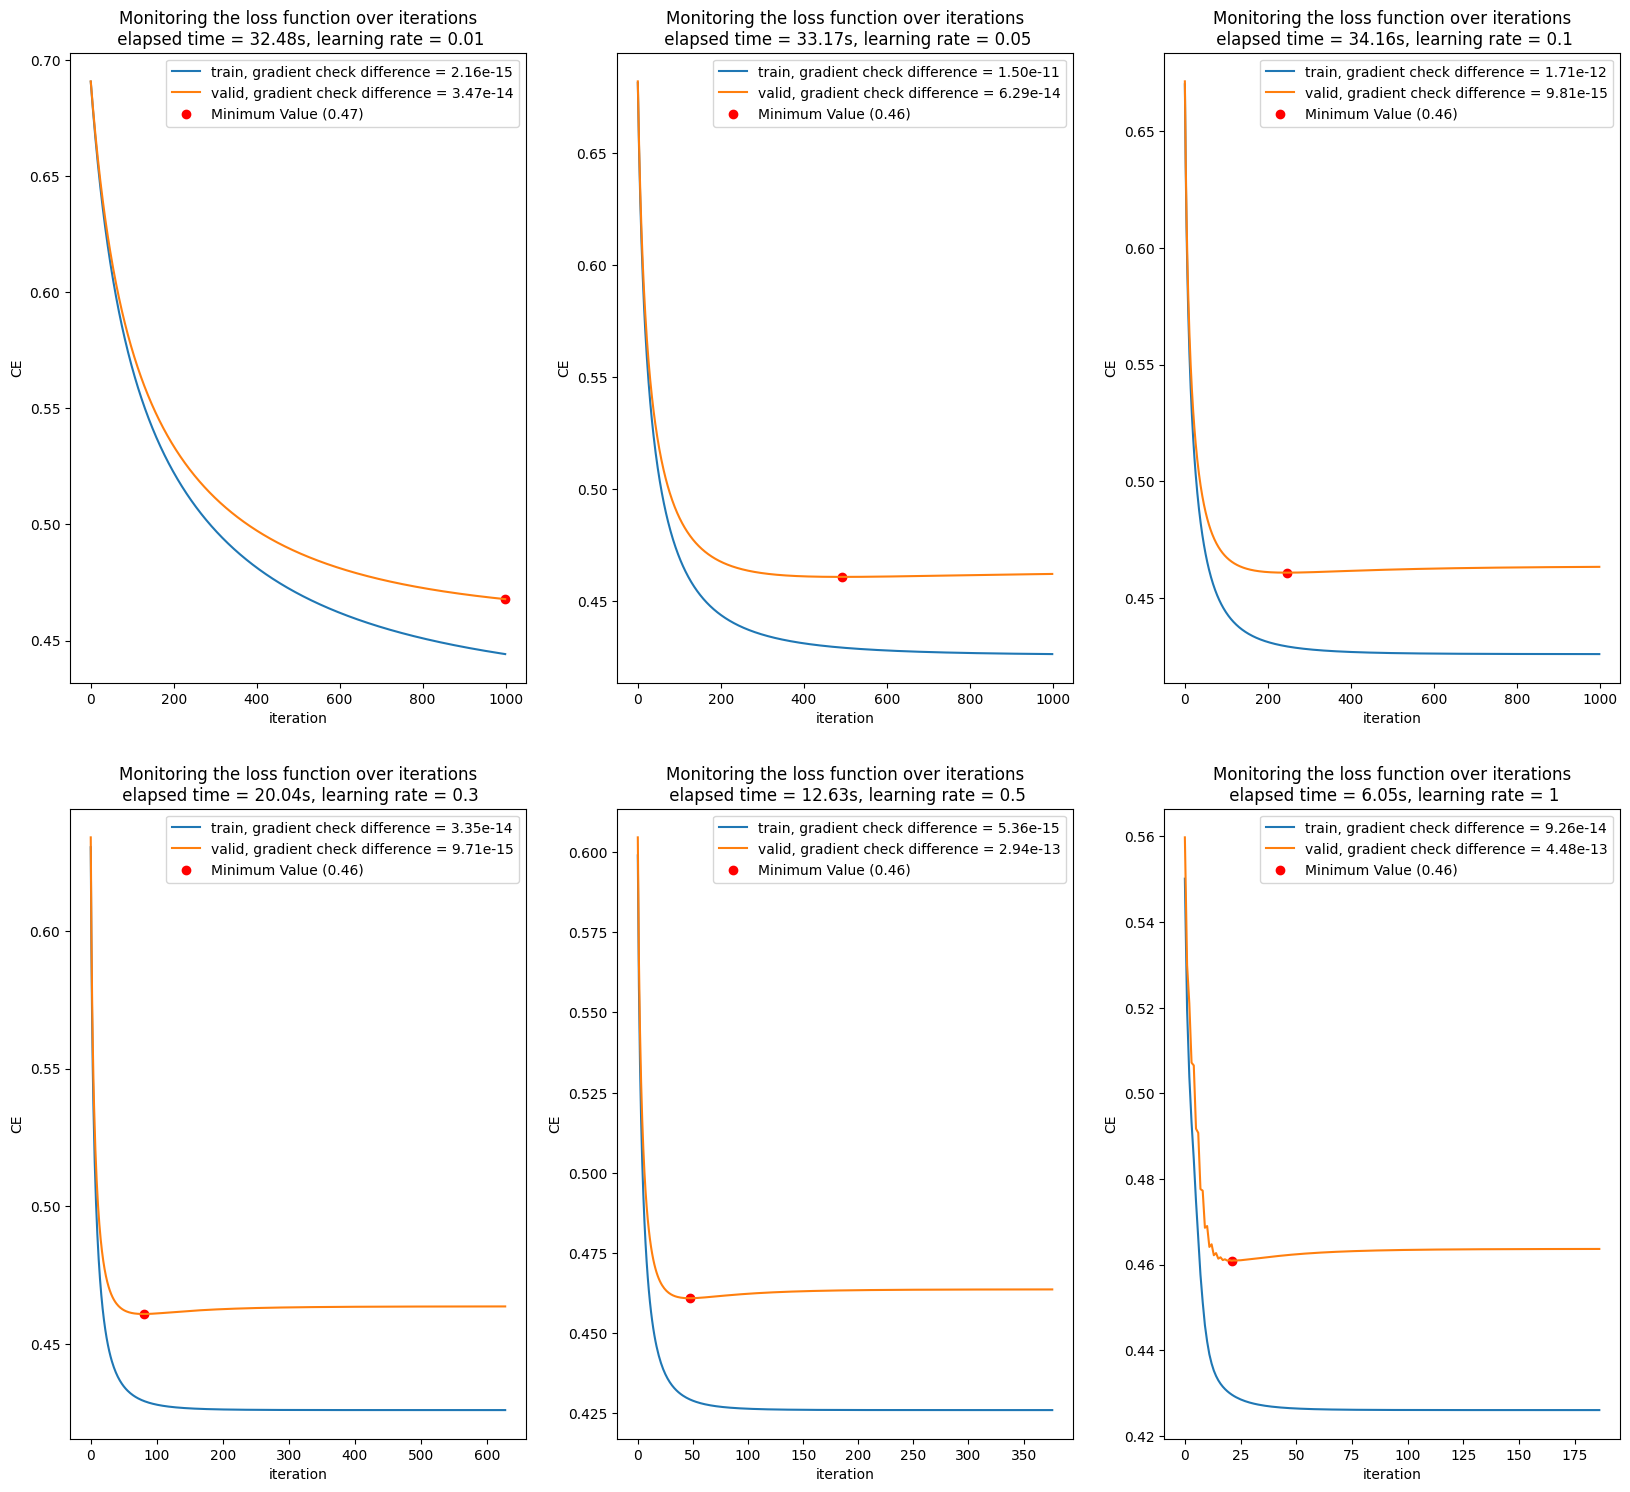

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Preparing the train and validation data
x_selected_training = x_training[:,selected_features]
y_binary_training = (y_training>5).astype(int)

x_train, x_valid, y_train, y_valid = train_test_split(standardization(x_selected_training), y_binary_training, test_size=0.3, random_state=42)
print("input characteristics:",x_train.min(), x_train.max(), x_train.mean(),y_train.min(), y_train.max())

learning_rate_subset = [0.01, 0.05, 0.1, 0.3, 0.5, 1]
plt.figure(figsize=(20, 18))
for i, learning_rate in enumerate(learning_rate_subset):
    # Monitor the model performance using gradientd cecking and CE monitoring
    model_logistic = LogisticRegression(max_iters=1000, learning_rate=learning_rate)

    # Record the start time
    start_time = time.time()

    ce_train, ce_valid = model_logistic.fit(x_train,y_train,x_valid,y_valid)

    # Record the end time
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    min_index = ce_valid.index(min(ce_valid))
    # # print(min_index)

    gradchecker_train = model_logistic.check_grad(x_train, y_train)
    print(gradchecker_train)
    gradchecker_valid = model_logistic.check_grad(x_valid, y_valid)
    # print(gradchecker_valid)

    # print(gradnorm_train.min())
    # print(ce_train)


    plt.subplot(2,3,i+1)
    # Plot the train loss
    plt.plot(ce_train, label=f'train, gradient check difference = {gradchecker_train:.2e}')
    # Plot the validation loss
    plt.plot(ce_valid, label=f'valid, gradient check difference = {gradchecker_valid:.2e}')
    # Mark the minimum point
    plt.scatter(min_index, ce_valid[min_index], color='red', label=f'Minimum Value ({ce_valid[min_index]:.2f})')

    # plt.plot(ce_valid/X_valid.shape[0], label='valid')
    plt.title(f"Monitoring the loss function over iterations\n elapsed time = {elapsed_time:.2f}s, learning rate = {learning_rate}")
    plt.xlabel("iteration")
    plt.ylabel("CE")
    plt.legend()

plt.savefig(f'CE_Monitoring.png', bbox_inches='tight')
plt.show()
files.download(f'CE_Monitoring.png')



In [ ]:
# Assign the appropriate learning rate and weights
model_logistic = LogisticRegression(max_iters=1000, learning_rate=0.5)
ce_train, ce_valid = model_logistic.fit(x_train,y_train,x_valid,y_valid)
min_index = ce_valid.index(min(ce_valid))
# print(len(model_logistic.Weights[0]))
model_logistic.w = model_logistic.Weights[min_index]
print(min_index)
print(f"loss for the selected weights: {model_logistic.ce(np.column_stack([x_valid,np.ones(x_valid.shape[0])]),y_valid)}")   # Just to check

47
loss for the selected weights: 0.46089421340907705


input characteristics: -0.6801951067237103 96.02738791216366 0.00011579169617409846 0 1


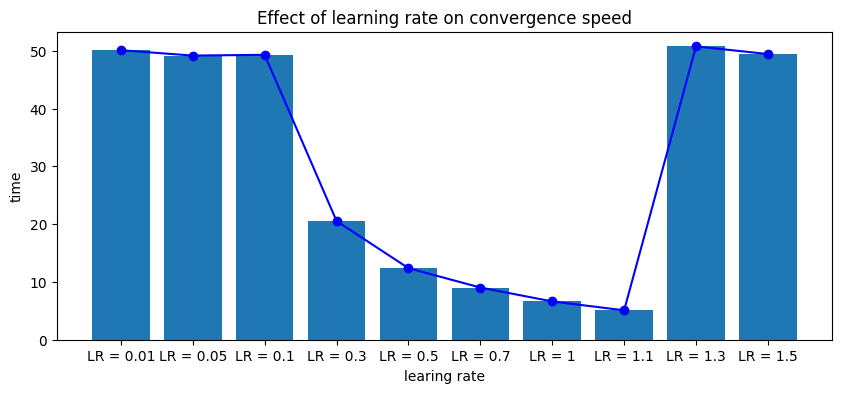

In [ ]:
# Effect of learning rate on speed of convergance
# Preparing the train and validation data
x_selected_training = x_training[:,selected_features]
y_binary_training = (y_training>5).astype(int)

x_train, x_valid, y_train, y_valid = train_test_split(standardization(x_selected_training), y_binary_training, test_size=0.3, random_state=42)
print("input characteristics:",x_train.min(), x_train.max(), x_train.mean(),y_train.min(), y_train.max())

learning_rate_subset = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1, 1.1, 1.3, 1.5]
elapsed_times = []
for learning_rate in learning_rate_subset:
    # Monitor the model performance using gradientd cecking and CE monitoring
    model_logistic = LogisticRegression(max_iters=1500, learning_rate=learning_rate)

    # Record the start time
    start_time = time.time()

    ce_train, ce_valid = model_logistic.fit(x_train,y_train,x_valid,y_valid)

    # Record the end time
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time


    elapsed_times.append(elapsed_time)

plt.figure(figsize=(10, 4))
# Plot the elapsed times
plt.bar(['LR = ' + str(lr) for lr in learning_rate_subset], elapsed_times)
plt.plot(['LR = ' + str(lr) for lr in learning_rate_subset], elapsed_times, '-o', color = 'blue')
plt.title("Effect of learning rate on convergence speed")
plt.xlabel("learing rate")
plt.ylabel("time")
# plt.savefig(f'conv_speed.png', bbox_inches='tight')
plt.show()
# files.download(f'conv_speed.png')



20-Newsgroups Data:

Compute classification accuracy:

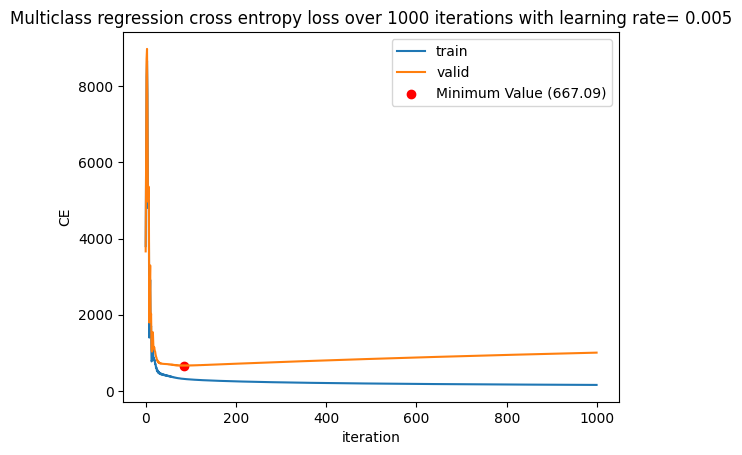

In [ ]:
## basic version with pre-set learning rate of 0.005
ce_train_news, ce_valid_news = mlr.fit(X_train_news, y_train_news, X_valid_news, y_valid_news, niter=1000,stop_early=False)
min_index = np.argmin(ce_valid_news)

plt.clf()
#plt.plot(ce_train_news/X_train_news.shape[0], label='train')
#plt.plot(ce_valid_news/X_valid_news.shape[0], label='valid')
plt.plot(ce_train_news, label='train')
plt.plot(ce_valid_news, label='valid')
plt.scatter(min_index, ce_valid_news[min_index], color='red', label=f'Minimum Value ({ce_valid_news[min_index]:.2f})')
plt.title(f"Multiclass regression cross entropy loss over 1000 iterations with learning rate= 0.005")
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
# plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

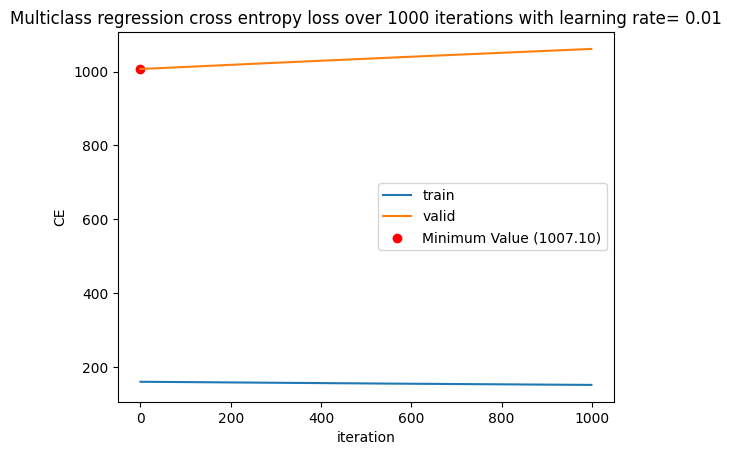

In [ ]:
## basic version with pre-set learning rate of 0.001
ce_train_news, ce_valid_news = mlr.fit(X_train_news, y_train_news, X_valid_news, y_valid_news, lr = 0.001, niter=1000,stop_early = False)
min_index = np.argmin(ce_valid_news)

plt.clf()
# plt.plot(ce_train_news/X_train_news.shape[0], label='train')
# plt.plot(ce_valid_news/X_valid_news.shape[0], label='valid')

plt.plot(ce_train_news, label='train')
plt.plot(ce_valid_news, label='valid')

plt.scatter(min_index, ce_valid_news[min_index], color='red', label=f'Minimum Value ({ce_valid_news[min_index]:.2f})')
plt.title(f"Multiclass regression cross entropy loss over 1000 iterations with learning rate= 0.01")
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
# plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

2.957084294772211e-09
1.3687787450820616e-06
4.83955002536359e-10
9.288818634912174e-11
1.5260290858603026e-10
2.0605975485105275e-10
5.551241584352294e-09
1.096933098429754e-06
2.1474667795355288e-11
6.580450766586645e-12


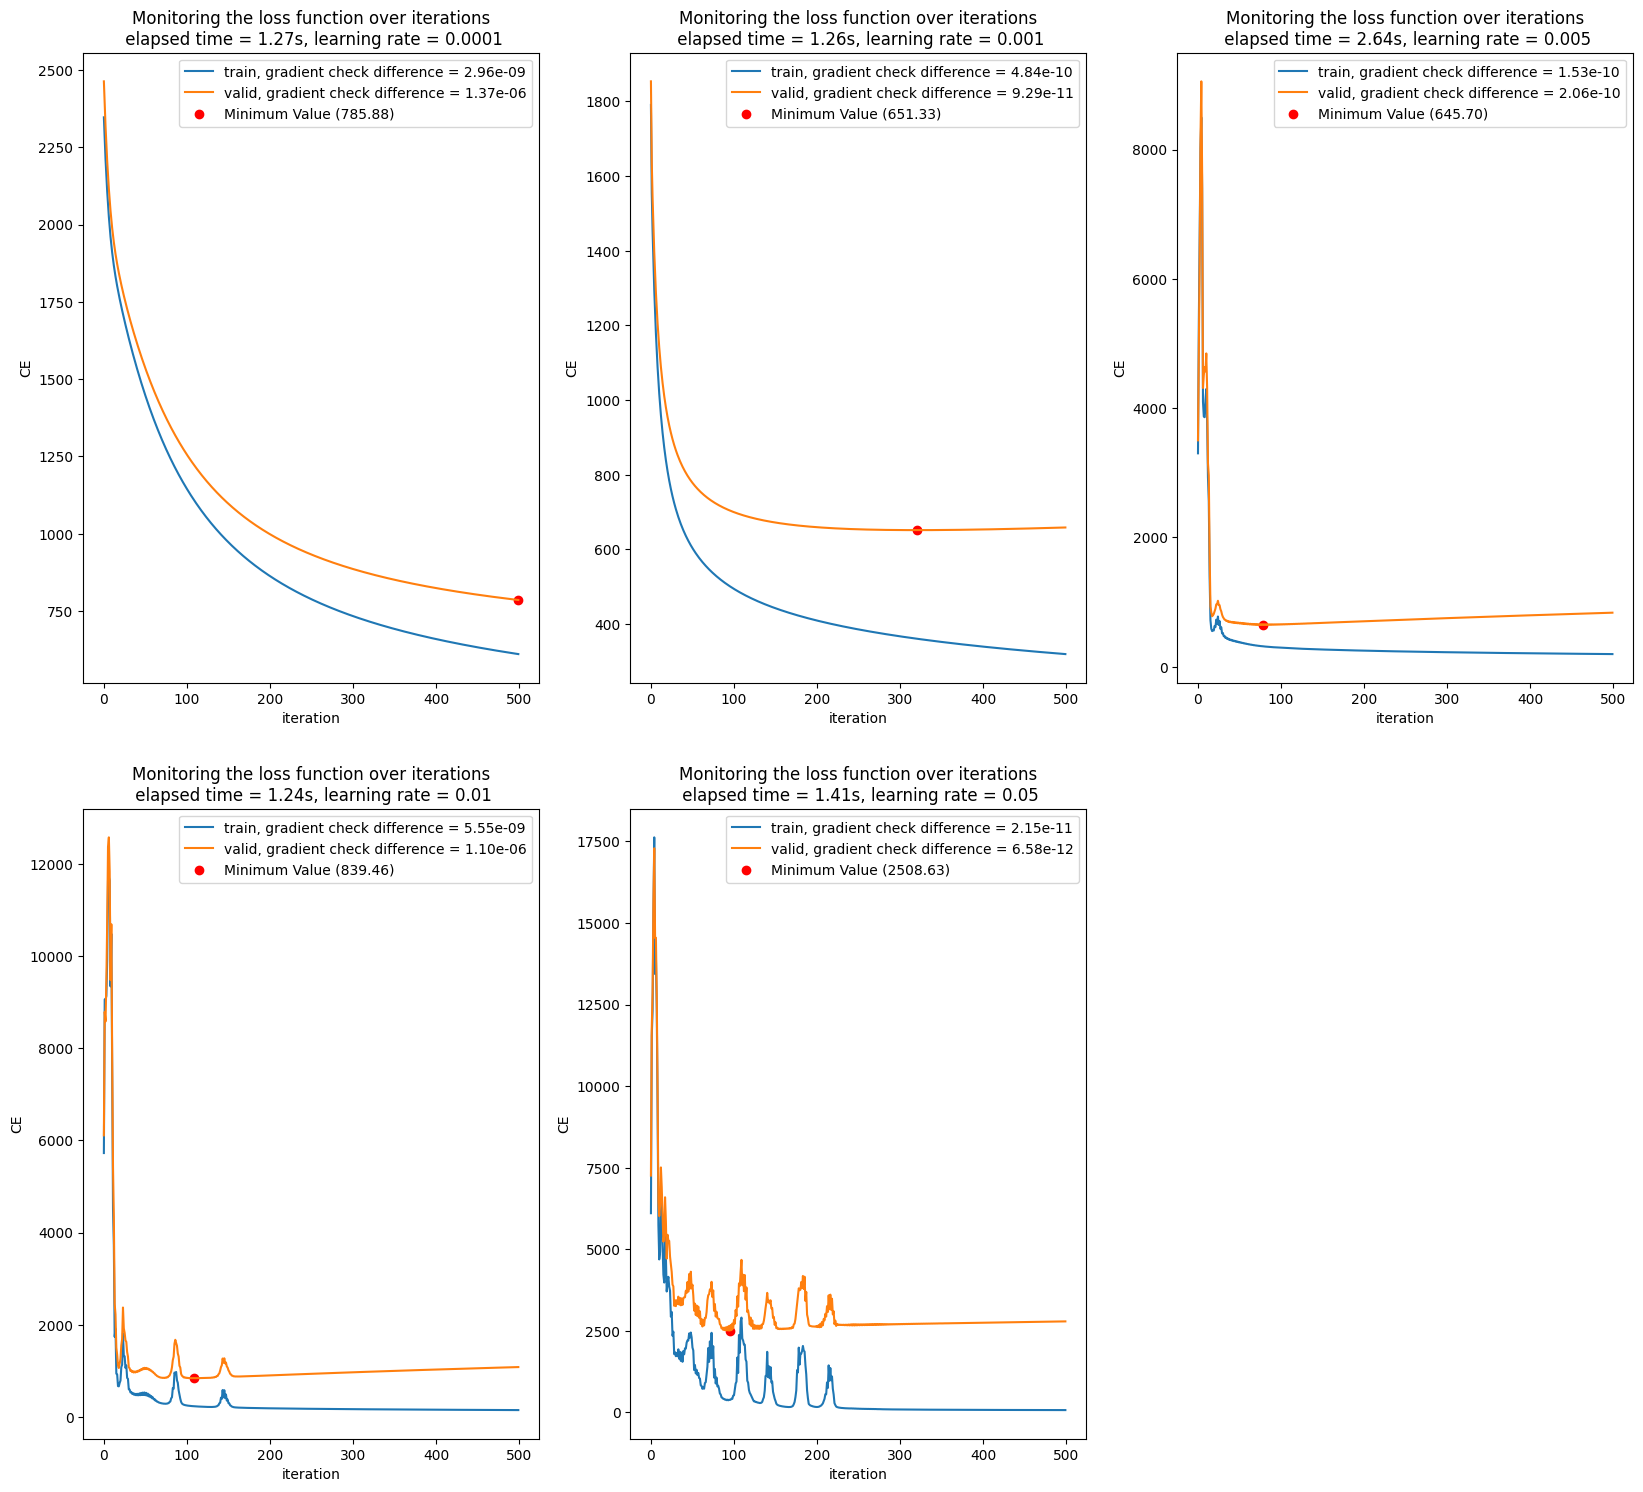

In [ ]:
#learning_rate_subset = [0.0000000001, 0.0000001, 0.00001, 0.0001, 0.001, 0.005]
learning_rate_subset = [0.0001, 0.001, 0.005, 0.01, 0.05]
#learning_rate_subset = [0.01, 0.05, 0.1, 0.3, 0.5, 1]
plt.figure(figsize=(20, 18))
for i, learning_rate in enumerate(learning_rate_subset):

  D = x_news_matrix.shape[1]
  C = y_news_matrix.shape[1]

  mlr = Multinomial_logistic(D, C)
  gradchecker_train = mlr.check_grad(X_train_news, y_train_news)
  gradchecker_valid = mlr.check_grad(X_valid_news, y_valid_news)
  print(gradchecker_train)
  print(gradchecker_valid)

  start_time = time.time()
  ce_train_news, ce_valid_news = mlr.fit(X_train_news, y_train_news, X_valid_news, y_valid_news, lr = learning_rate, niter=500,stop_early=False)
  end_time = time.time()
  elapsed_time = end_time - start_time

  #min_index = ce_valid_news.index(min(ce_valid_news))
  min_index = np.argmin(ce_valid_news)



  plt.subplot(2,3,i+1)
  # Plot the train loss

  # plt.plot(ce_train_news/X_train_news.shape[0], label=f'train, gradient check difference = {gradchecker_train:.2e}')
  # plt.plot(ce_valid_news/X_valid_news.shape[0], label=f'valid, gradient check difference = {gradchecker_valid:.2e}')

  plt.plot(ce_train_news, label=f'train, gradient check difference = {gradchecker_train:.2e}')
  # Plot the validation loss
  plt.plot(ce_valid_news, label=f'valid, gradient check difference = {gradchecker_valid:.2e}')
  # Mark the minimum point
  plt.scatter(min_index, ce_valid_news[min_index], color='red', label=f'Minimum Value ({ce_valid_news[min_index]:.2f})')

  # plt.plot(ce_valid/X_valid.shape[0], label='valid')
  plt.title(f"Monitoring the loss function over iterations\n elapsed time = {elapsed_time:.2f}s, learning rate = {learning_rate}")
  plt.xlabel("iteration")
  plt.ylabel("CE")
  plt.legend()

plt.savefig(f'CE_Monitoring.png', bbox_inches='tight')
plt.show()


In [ ]:
model_2 = Multinomial_logistic(D, C)

model_2.fit(X_train_news, y_train_news)

train_news_accuracy = evaluate(model_2.predict(X_train_news), y_train_news)
valid_news_accuracy = evaluate(model_2.predict(X_valid_news), y_valid_news)
test_news_accuracy = evaluate(model_2.predict(X_test_news), y_test_news)

print(train_news_accuracy)
print(valid_news_accuracy)
print(test_news_accuracy)

0.8843398157625384
0.7627811860940695
0.7601246105919003


# Task 3: Experiments


## 1. Top and Bottom features

Horizontal bar plot showing top 20 features from logistic regression on IMDB dataset

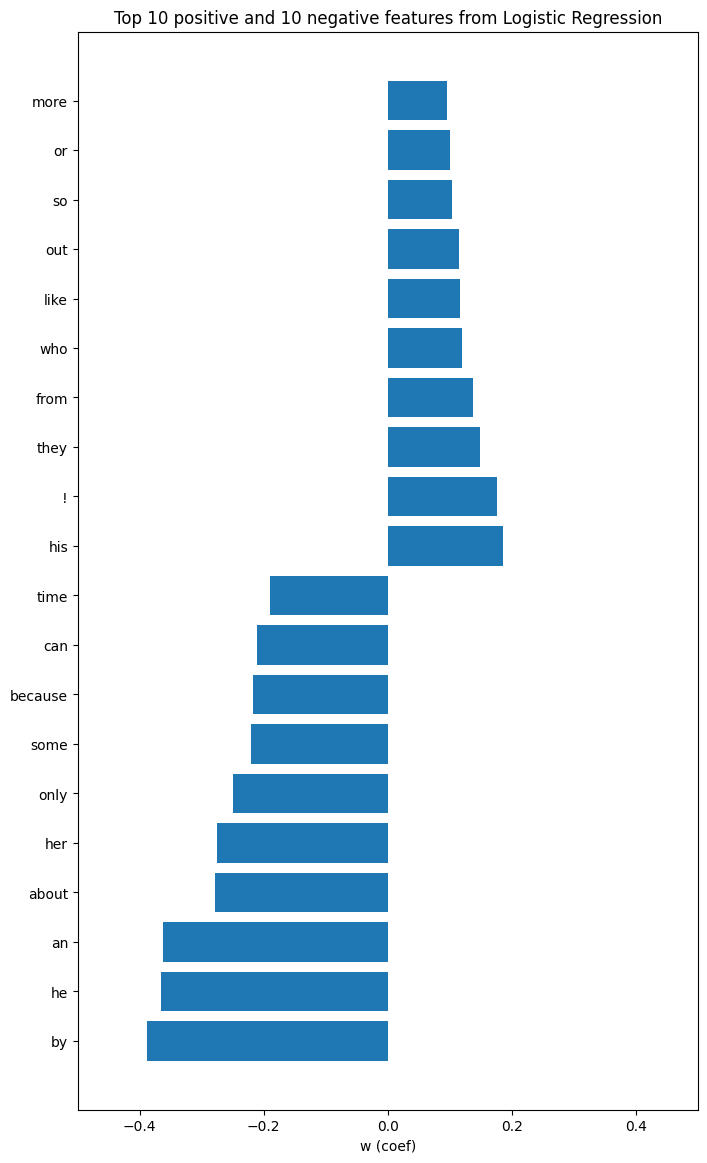

In [ ]:
num_features_vec = np.arange(num_features)
# print(polarized_words_str[:200])
weights_vec = model_logistic.w[:-1]
# Get the indices that would sort the data in descending order
sorted_indices_pos = np.argsort(weights_vec)[::-1]        # Sorting indices based on the values of weights (to collect highest positive ones)
sorted_indices_neg = np.argsort(weights_vec)              # Sorting indices based on the negative values of weights (to collect highest negative ones)

# Sort pos weights
sorted_num_features_vec_pos = num_features_vec[sorted_indices_pos]
sorted_weights_vec_pos = weights_vec[sorted_indices_pos]

# Sort neg weights
sorted_num_features_vec_neg = num_features_vec[sorted_indices_neg]
sorted_weights_vec_neg = weights_vec[sorted_indices_neg]

# print(sorted_weights_vec_pos)
# print(sorted_weights_vec_neg)

# Plot top pos and neg weights in a bar plot
plt.figure(figsize=(8, 14))
topweights = np.concatenate([sorted_weights_vec_pos[:10],sorted_weights_vec_neg[:10]])
topfeatures = np.concatenate([polarized_words_str[sorted_num_features_vec_pos[:10]],polarized_words_str[sorted_num_features_vec_neg[:10]]])
indices = np.argsort(abs(topweights))[::-1]
sorted_topfeatures = topfeatures[indices]
sorted_topweights = topweights[indices]
plt.barh(sorted_topfeatures, sorted_topweights)
plt.title('Top 10 positive and 10 negative features from Logistic Regression')
plt.xlabel('w (coef)')
plt.xlim([-0.5,0.5])
# plt.savefig(f'imdb_features_pos-neg20_logistic.png', bbox_inches='tight')
plt.show()
# files.download(f'imdb_features_pos-neg20_logistic.png')

## 2. Binary Classification and Multi-class Classification
Please see Task 2 for more details of the implementation


## 3. ROC Curves and AUROC
Plot ROC and AUROC values of logistic regression and Decision Trees on IMDB Dataset


In [ ]:
# Preparing the test data
x_testing, y_testing, _ = features_generator('./aclImdb', 'test')
x_standardized_testing = standardization(x_testing, True, x_training.mean(axis=0),x_training.std(axis=0))
x_test = x_standardized_testing[:,selected_features]
# print(sum(y_testing ==5))
y_test = (y_testing>5).astype(int)

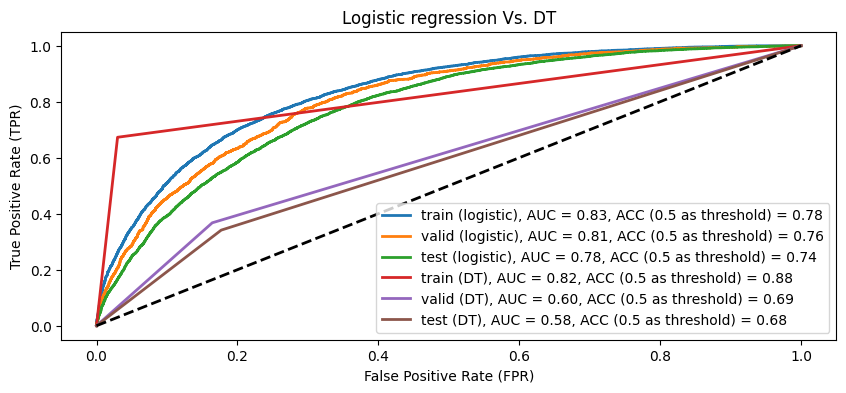

In [ ]:
# Use the logistic model to predict the train data
y_prob, y_pred = model_logistic.predict(x_train)
accuracy = evaluate_acc(y_train, y_pred)

fpr, tpr, thresholds = roc_curve(y_train, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 4))
# Plotting the ROC curve for train data
plt.plot(fpr, tpr, lw=2, label=f'train (logistic), AUC = {roc_auc:.2f}, ACC (0.5 as threshold) = {accuracy:.2f}')


# Use the logistic model to predict the validation data
y_prob, y_pred = model_logistic.predict(x_valid)
accuracy = evaluate_acc(y_valid, y_pred)

fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve for validation data
plt.plot(fpr, tpr, lw=2, label=f'valid (logistic), AUC = {roc_auc:.2f}, ACC (0.5 as threshold) = {accuracy:.2f}')

# Use the logistic model to predict the test data
y_prob, y_pred = model_logistic.predict(x_test)
accuracy = evaluate_acc(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve for validation data
plt.plot(fpr, tpr, lw=2, label=f'test (logistic), AUC = {roc_auc:.2f}, ACC (0.5 as threshold) = {accuracy:.2f}')



# Train a DT model
# model_DT = DecisionTreeClassifier()
model_DT = DecisionTreeClassifier(max_depth = 20)      # The max depth is derived through train and validation roc analysis on different depth values
model_DT.fit(x_train,y_train)

# Use DT model to predict the train data
y_prob = model_DT.predict(x_train)
accuracy = evaluate_acc(y_train, (y_prob>0.5).astype(int))

fpr, tpr, thresholds = roc_curve(y_train, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve for train data
plt.plot(fpr, tpr, lw=2, label=f'train (DT), AUC = {roc_auc:.2f}, ACC (0.5 as threshold) = {accuracy:.2f}')


# Use DT model to predict the validation data
y_prob = model_DT.predict(x_valid)
accuracy = evaluate_acc(y_valid, (y_prob>0.5).astype(int))

fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve for validation data
plt.plot(fpr, tpr, lw=2, label=f'valid (DT), AUC = {roc_auc:.2f}, ACC (0.5 as threshold) = {accuracy:.2f}')



# Use DT model to predict the test data
y_prob = model_DT.predict(x_test)
accuracy = evaluate_acc(y_test, (y_prob>0.5).astype(int))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve for test data
plt.plot(fpr, tpr, lw=2, label=f'test (DT), AUC = {roc_auc:.2f}, ACC (0.5 as threshold) = {accuracy:.2f}')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Logistic regression Vs. DT')
plt.legend(loc='lower right' )

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='dummy AUC = 0.5')
# plt.savefig(f'LR_DT.png', bbox_inches='tight')
plt.show()
# files.download(f'LR_DT.png')



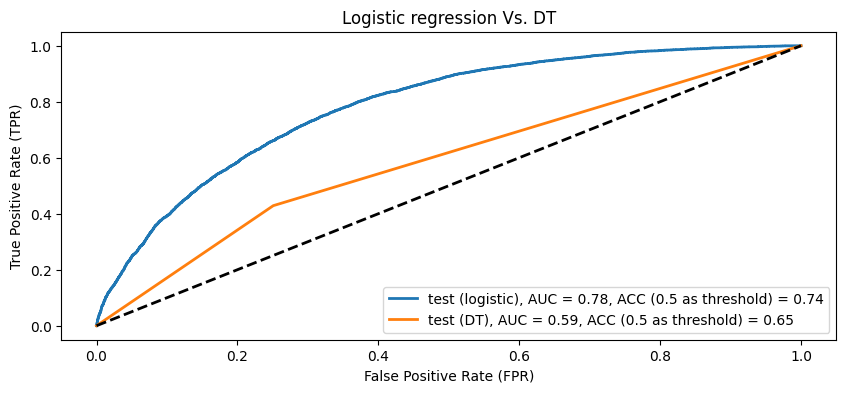

In [ ]:
#### NEED A GRAPH WITH JUST 2 LINES --> one for logistic regression and one for DT
plt.figure(figsize=(10, 4))

# Use the logistic model to predict the test data
y_prob, y_pred = model_logistic.predict(x_test)
accuracy = evaluate_acc(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve for validation data
plt.plot(fpr, tpr, lw=2, label=f'test (logistic), AUC = {roc_auc:.2f}, ACC (0.5 as threshold) = {accuracy:.2f}')



# Use DT model to predict the test data
y_prob = model_DT.predict(x_test)
accuracy = evaluate_acc(y_test, (y_prob>0.5).astype(int))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve for test data
plt.plot(fpr, tpr, lw=2, label=f'test (DT), AUC = {roc_auc:.2f}, ACC (0.5 as threshold) = {accuracy:.2f}')


plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Logistic regression Vs. DT')
plt.legend(loc='lower right' )

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='dummy AUC = 0.5')
# plt.savefig(f'LR_DT.png', bbox_inches='tight')
plt.show()
# files.download(f'LR_DT.png')

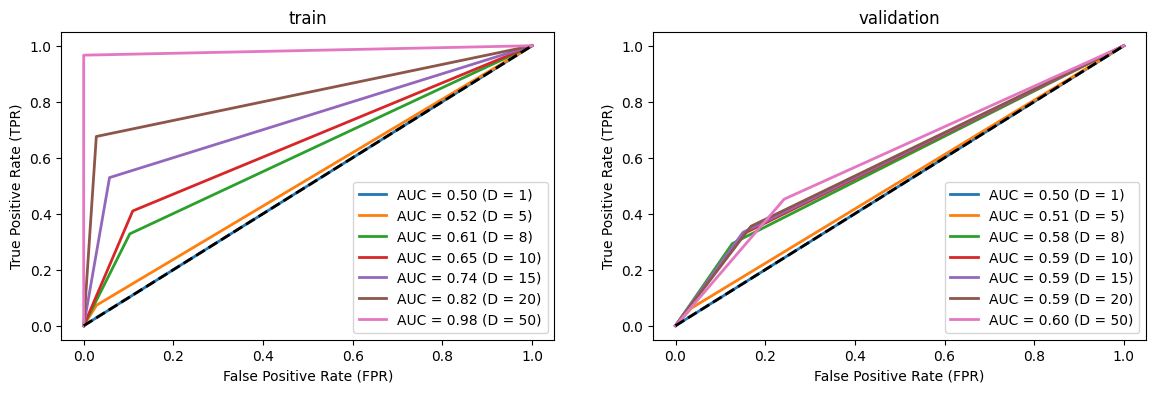

In [ ]:
subset_depth = np.array([1,5,8,10,15,20,50])
plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)
for max_depth in subset_depth:
  model_DT = DecisionTreeClassifier(max_depth=max_depth)
  model_DT.fit(x_train,y_train)
  y_prob = model_DT.predict(x_train)

  # Compute ROC curve and area under the curve (AUC)
  fpr, tpr, thresholds = roc_curve(y_train, y_prob)
  roc_auc = auc(fpr, tpr)

  # Plotting the ROC curve
  plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f} (D = {model_DT.max_depth})')
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title('train')
  plt.legend(loc='lower right' )
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='dummy AUC = 0.5')

plt.subplot(1,2,2)
for max_depth in subset_depth:
  model_DT = DecisionTreeClassifier(max_depth=max_depth)
  model_DT.fit(x_train,y_train)
  y_prob = model_DT.predict(x_valid)

  # Compute ROC curve and area under the curve (AUC)
  fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
  roc_auc = auc(fpr, tpr)

  # Plotting the ROC curve
  plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f} (D = {model_DT.max_depth})')
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title('validation')
  plt.legend(loc='lower right' )
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='dummy AUC = 0.5')


# plt.savefig(f'tain_testDT.png', bbox_inches='tight')
plt.show()
# files.download(f'tain_testDT.png')



## 4. Multiclass Accuracy
Report the multiclass classification accuracy of multiclass linear regression and Decision Trees on the 5 chosen classes from the 20-news-group data

Best Depth =  40 , Test Accuracy =  0.6095534787123572


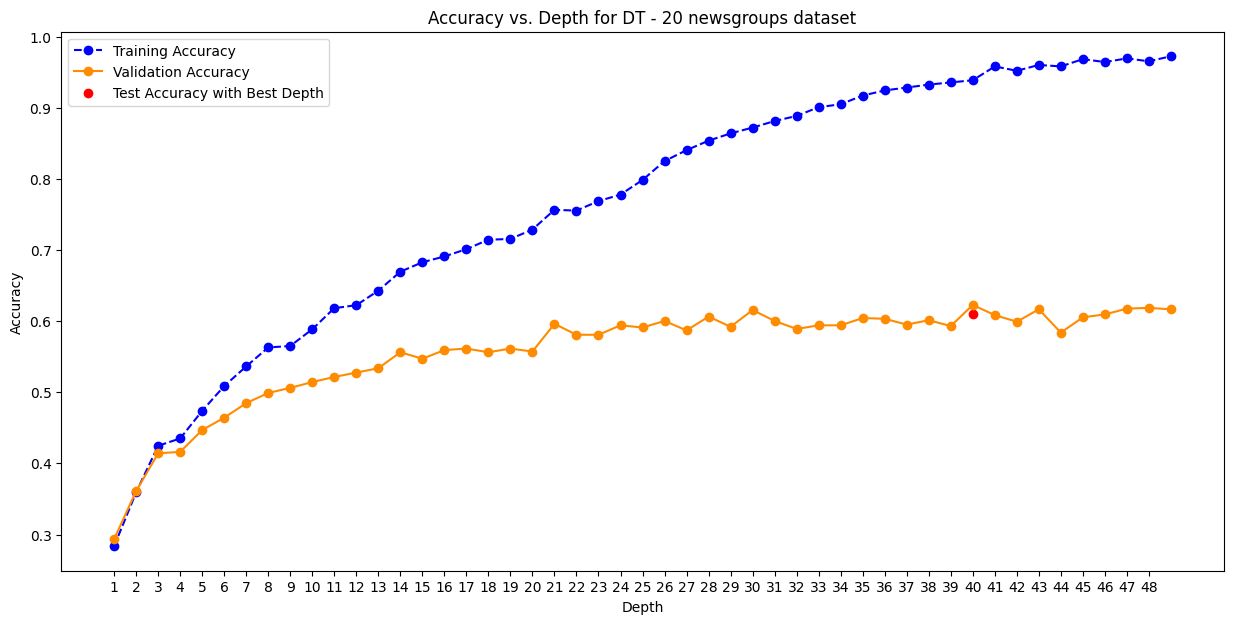

In [ ]:
train_accs = {}
val_accs = {}

for depth in range(1, 50):
  multi_model_DT = DecisionTreeClassifier(max_depth = depth)

  train_probs =  multi_model_DT.fit(X_train_news, y_train_news).predict(X_train_news)
  train_accuracy = evaluate(train_probs, y_train_news)

  val_probs = multi_model_DT.predict(X_valid_news)
  val_accuracy = evaluate(val_probs, y_valid_news)

  train_accs[depth] = train_accuracy
  val_accs[depth] = val_accuracy

best_depth = max(val_accs, key=val_accs.get)
test_DT = DecisionTreeClassifier(max_depth = best_depth)
test_probs = test_DT.fit(X_train_news, y_train_news).predict(X_test_news)
test_accuracy = evaluate(test_probs, y_test_news)
print("Best Depth = ", best_depth, ", Test Accuracy = ", test_accuracy)



plt.figure(figsize=(15, 7))
plt.plot(list(train_accs.keys()), list(train_accs.values()), marker='o', linestyle='--', color='blue', label='Training Accuracy')
plt.plot(list(train_accs.keys()), list(val_accs.values()), marker='o', color='darkorange', label='Validation Accuracy')
plt.scatter(best_depth, test_accuracy, color='red', label='Test Accuracy with Best Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Depth for DT - 20 newsgroups dataset')
plt.xlabel('Depth')
plt.xticks(range(1, len(train_accs)))
#plt.yticks(range(0,1))
#plt.grid(True)
plt.show()

## 5. Compare Model Accuracy

Plot/compute the accuracy of two models as functinos of size of dataset by controlling the training size.
Randomly select 20%, 40%, 60%, 80%,100% of available training data and train your model on this subset and evaluate on held-out test set.


IMDB Dataset - Logistic Regression:

Bar plot that shows AUROC of logistic regression and DT

In [ ]:
subset_testratio = [90,80,60,40,20,0]
roc_auc_trains_LR = []
roc_auc_valids_LR = []
roc_auc_tests_LR = []
roc_auc_trains_DT = []
roc_auc_valids_DT = []
roc_auc_tests_DT = []

for r in subset_testratio:
    if r != 0:
        # Split the data into train and validation
        x_train, x_valid, y_train, y_valid = train_test_split(standardization(x_selected_training), y_binary_training, test_size=r/100, random_state=42)

        # Train the logistic model
        model_logistic = LogisticRegression(max_iters=47, learning_rate=0.5)
        model_logistic.fit(x_train,y_train)

        # Use the logistic model to predict the train data
        y_prob, _ = model_logistic.predict(x_train)

        fpr, tpr, thresholds = roc_curve(y_train, y_prob)
        roc_auc_trains_LR.append(auc(fpr, tpr))


        # Use the logistic model to predict the validation data
        y_prob, _ = model_logistic.predict(x_valid)

        fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
        roc_auc_valids_LR.append(auc(fpr, tpr))


        # Use the logistic model to predict the test data
        y_prob, _ = model_logistic.predict(x_test)

        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc_tests_LR.append(auc(fpr, tpr))


        # Train a DT model
        model_DT = DecisionTreeClassifier(max_depth = 20)      # The max depth is derived through train and validation roc analysis on different depth values
        model_DT.fit(x_train,y_train)

        # Use DT model to predict the train data
        y_prob = model_DT.predict(x_train)

        fpr, tpr, thresholds = roc_curve(y_train, y_prob)
        roc_auc_trains_DT.append(auc(fpr, tpr))

        # Use DT model to predict the validation data
        y_prob = model_DT.predict(x_valid)

        fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
        roc_auc_valids_DT.append(auc(fpr, tpr))

        # Use DT model to predict the test data
        y_prob = model_DT.predict(x_test)

        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc_tests_DT.append(auc(fpr, tpr))

    else:
        # Use the whole data for training
        x_train, y_train = standardization(x_selected_training), y_binary_training

        # Train the logistic model
        model_logistic = LogisticRegression(max_iters=47, learning_rate=0.5)
        model_logistic.fit(x_train,y_train)

        # Use the logistic model to predict the train data
        y_prob, _ = model_logistic.predict(x_train)

        fpr, tpr, thresholds = roc_curve(y_train, y_prob)
        roc_auc_trains_LR.append(auc(fpr, tpr))

        # Use the logistic model to predict the test data
        y_prob, _ = model_logistic.predict(x_test)

        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc_tests_LR.append(auc(fpr, tpr))



        # Train a DT model
        model_DT = DecisionTreeClassifier(max_depth = 20)      # The max depth is derived through train and validation roc analysis on different depth values
        model_DT.fit(x_train,y_train)

        # Use DT model to predict the train data
        y_prob = model_DT.predict(x_train)

        fpr, tpr, thresholds = roc_curve(y_train, y_prob)
        roc_auc_trains_DT.append(auc(fpr, tpr))

        # Use DT model to predict the test data
        y_prob = model_DT.predict(x_test)

        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc_tests_DT.append(auc(fpr, tpr))

plt.figure(figsize=(12,14))
plt.subplot(3, 1, 1)
plt.bar([str(100-r) + "% training size" for r in subset_testratio], roc_auc_trains_LR, label = "LR")
plt.plot([str(100-r) + "% training size" for r in subset_testratio], roc_auc_trains_LR, label = "LR", marker='o',color = 'blue')
plt.bar([str(100-r) + "% training size" for r in subset_testratio], roc_auc_trains_DT, label = "DT")
plt.plot([str(100-r) + "% training size" for r in subset_testratio], roc_auc_trains_DT, label = "DT", marker='o',color = 'red')

plt.legend()
plt.ylabel("AUROC")
plt.title('Training size effect on AUROC (prediction on the train data)')


plt.subplot(3, 1, 2)
plt.bar([str(100-r) + "% training size" for r in subset_testratio[:-1]], roc_auc_valids_LR, label = "LR")
plt.plot([str(100-r) + "% training size" for r in subset_testratio[:-1]], roc_auc_valids_LR, label = "LR", marker='o',color = 'blue')
plt.bar([str(100-r) + "% training size" for r in subset_testratio[:-1]], roc_auc_valids_DT, label = "DT")
plt.plot([str(100-r) + "% training size" for r in subset_testratio[:-1]], roc_auc_valids_DT, label = "DT", marker='o',color = 'red')
plt.legend()
plt.ylabel("AUROC")
plt.title('Training size effect on AUROC (prediction on the validation data)')



plt.subplot(3, 1, 3)
plt.bar([str(100-r) + "% training size" for r in subset_testratio], roc_auc_tests_LR, label = "LR")
plt.plot([str(100-r) + "% training size" for r in subset_testratio], roc_auc_tests_LR, label = "LR", marker='o',color = 'blue')
plt.bar([str(100-r) + "% training size" for r in subset_testratio], roc_auc_tests_DT, label = "DT")
plt.plot([str(100-r) + "% training size" for r in subset_testratio], roc_auc_tests_DT, label = "DT", marker='o',color = 'red')

plt.legend()
plt.ylabel("AUROC")
plt.title('Training size effect on AUROC (prediction on the test data)')

# plt.savefig(f'trainingsize_logistic.png', bbox_inches='tight')
plt.show()
# files.download(f'trainingsize_logistic.png')

20-newsgroups dataset:

Bar plot that shows classification accuracies of multiclass regression and DT

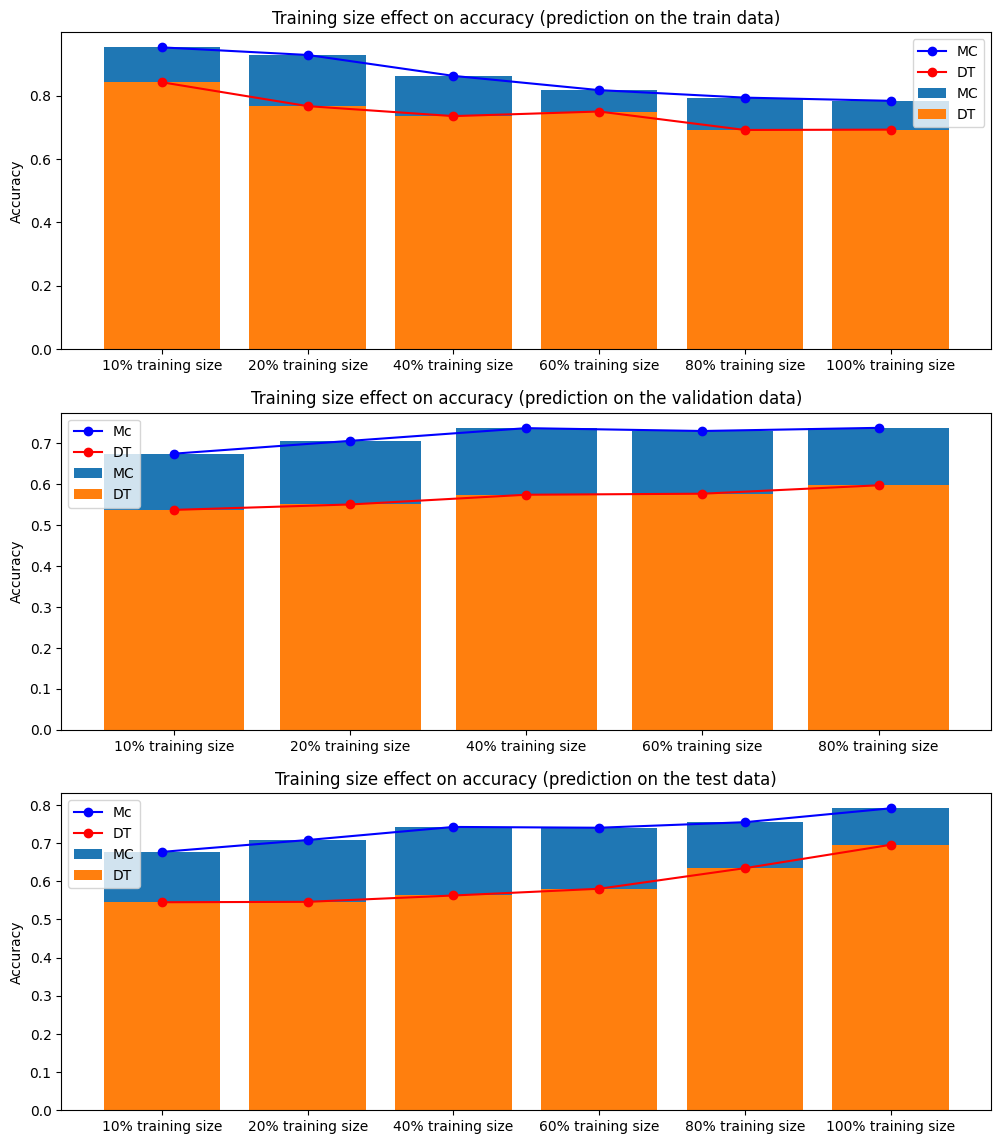

In [ ]:
## NOT DONE

subset_testratio = [90,80,60,40,20,0]
accuracy_trains_MC = []
accuracy_valids_MC = []
accuracy_tests_MC = []
accuracy_trains_DT = []
accuracy_valids_DT = []
accuracy_tests_DT = []

for r in subset_testratio:
    if r != 0:
        # Split the data into train and validation
        X_train_news, X_valid_news, y_train_news, y_valid_news = train_test_split(x_news_matrix, y_news_matrix, test_size=r/100, random_state=42)

        # Train the multiclass model
        D = x_news_matrix.shape[1]
        C = y_news_matrix.shape[1]

        multi_model = Multinomial_logistic(D, C)
        multi_model.fit(X_train_news, y_train_news)

        # Use the multiclass model to predict the train data
        train_probs = multi_model.predict(X_train_news)
        train_accuracy = evaluate(train_probs, y_train_news)
        accuracy_trains_MC.append(train_accuracy)


        # Use the multiclass model to predict the validation data
        val_probs = multi_model.predict(X_valid_news)
        val_accuracy = evaluate(val_probs, y_valid_news)
        accuracy_valids_MC.append(val_accuracy)


        # Use the multiclass model to predict the test data
        test_probs = multi_model.predict(X_test_news)
        test_accuracy = evaluate(test_probs, y_test_news)
        accuracy_tests_MC.append(test_accuracy)


        # Train a DT model
        model_DT = DecisionTreeClassifier(max_depth = 20)      # The max depth is derived through train and validation accuracy analysis on different depth values
        model_DT.fit(X_train_news, y_train_news)

        # Use DT model to predict the train data
        y_prob = model_DT.predict(X_train_news)
        train_accuracy = evaluate(y_prob, y_train_news)
        accuracy_trains_DT.append(train_accuracy)


        # Use DT model to predict the validation data
        y_prob = model_DT.predict(X_valid_news)
        val_accuracy = evaluate(y_prob, y_valid_news)
        accuracy_valids_DT.append(val_accuracy)

        # Use DT model to predict the test data
        y_prob = model_DT.predict(X_test_news)
        test_accuracy = evaluate(y_prob, y_test_news)
        accuracy_tests_DT.append(test_accuracy)




    else:
        # Use the whole data for training
        X_train_news, y_train_news = x_news_matrix, y_news_matrix
        D = x_news_matrix.shape[1]
        C = y_news_matrix.shape[1]

        # Train the multiclass model
        multi_model = Multinomial_logistic(D, C)
        multi_model.fit(X_train_news, y_train_news)

        # Use the multiclass model to predict the train data
        train_probs = multi_model.predict(X_train_news)
        train_accuracy = evaluate(train_probs, y_train_news)
        accuracy_trains_MC.append(train_accuracy)

        # Use the multiclass model to predict the test data
        test_probs = multi_model.predict(X_test_news)
        test_accuracy = evaluate(test_probs, y_test_news)
        accuracy_tests_MC.append(test_accuracy)



        # Train a DT model
        model_DT = DecisionTreeClassifier(max_depth = 20)      # The max depth is derived through train and validation roc analysis on different depth values
        model_DT.fit(X_train_news, y_train_news)

        # Use DT model to predict the train data
        y_prob = model_DT.predict(X_train_news)
        train_accuracy = evaluate(y_prob, y_train_news)
        accuracy_trains_DT.append(train_accuracy)

        # Use DT model to predict the test data
        y_prob = model_DT.predict(X_test_news)
        test_accuracy = evaluate(y_prob, y_test_news)
        accuracy_tests_DT.append(test_accuracy)


plt.figure(figsize=(12,14))
plt.subplot(3, 1, 1)
plt.bar([str(100-r) + "% training size" for r in subset_testratio], accuracy_trains_MC, label = "MC")
plt.plot([str(100-r) + "% training size" for r in subset_testratio], accuracy_trains_MC, label = "MC", marker='o',color = 'blue')
plt.bar([str(100-r) + "% training size" for r in subset_testratio], accuracy_trains_DT, label = "DT")
plt.plot([str(100-r) + "% training size" for r in subset_testratio], accuracy_trains_DT, label = "DT", marker='o',color = 'red')

plt.legend()
plt.ylabel("Accuracy")
plt.title('Training size effect on accuracy (prediction on the train data)')


plt.subplot(3, 1, 2)
plt.bar([str(100-r) + "% training size" for r in subset_testratio[:-1]], accuracy_valids_MC, label = "MC")
plt.plot([str(100-r) + "% training size" for r in subset_testratio[:-1]], accuracy_valids_MC, label = "Mc", marker='o',color = 'blue')
plt.bar([str(100-r) + "% training size" for r in subset_testratio[:-1]], accuracy_valids_DT, label = "DT")
plt.plot([str(100-r) + "% training size" for r in subset_testratio[:-1]], accuracy_valids_DT, label = "DT", marker='o',color = 'red')
plt.legend()
plt.ylabel("Accuracy")
plt.title('Training size effect on accuracy (prediction on the validation data)')



plt.subplot(3, 1, 3)
plt.bar([str(100-r) + "% training size" for r in subset_testratio], accuracy_tests_MC, label = "MC")
plt.plot([str(100-r) + "% training size" for r in subset_testratio], accuracy_tests_MC, label = "Mc", marker='o',color = 'blue')
plt.bar([str(100-r) + "% training size" for r in subset_testratio], accuracy_tests_DT, label = "DT")
plt.plot([str(100-r) + "% training size" for r in subset_testratio], accuracy_tests_DT, label = "DT", marker='o',color = 'red')

plt.legend()
plt.ylabel("Accuracy")
plt.title('Training size effect on accuracy (prediction on the test data)')

plt.savefig(f'trainingsize_multiclass.png', bbox_inches='tight')
plt.show()

## Additional:

- different learning rates
- investigate stopping criteria
- linear regression for predicting ratings
- alternate text embeddings
- try other models
- more than 5 classes



Heatmap showing top 5 most positive features as rows for each class as columns in multiclass classification on 4 chosen classes from 20-newsgroups dataset

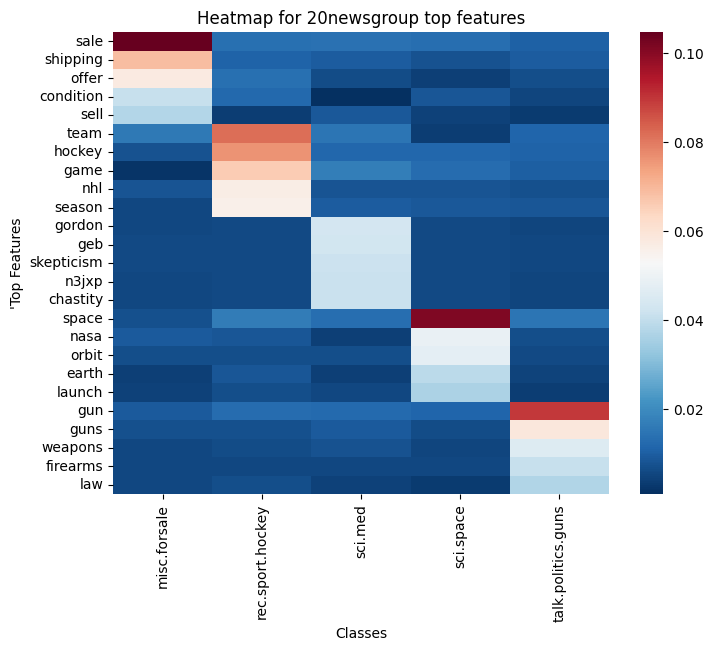

In [ ]:
feature_words_matrix = np.zeros((25, 5))

# make list of heapmap words
heapmap_words = []
for l in heatmap_scores.values():
    for word, score in l:
      heapmap_words.append(word)



w = 0
while w < len(heapmap_words):
  c = 0
  while c < 5:
    inner_dict = list(all_feature_words.values())
    inner_dict = inner_dict[0]

    # get MI score for the word
    if all_feature_words[c][heapmap_words[w]] != None:
      mi_score = all_feature_words[c][heapmap_words[w]]
      feature_words_matrix[w][c] = mi_score
    c+=1
  w+=1

#print(feature_words_matrix)
#print(top_feature_words)


plt.figure(figsize=(8,6))
sns.heatmap(feature_words_matrix,cmap = 'RdBu_r', xticklabels=news_train.target_names, yticklabels =heapmap_words)
plt.xlabel('Classes')
plt.ylabel("'Top Features")
plt.title('Heatmap for 20newsgroup top features')
plt.show()

# LASSO Regression

Testing on 20-news groups dataset

Best alpha =  0.001 Test set score: 0.7601246105919003


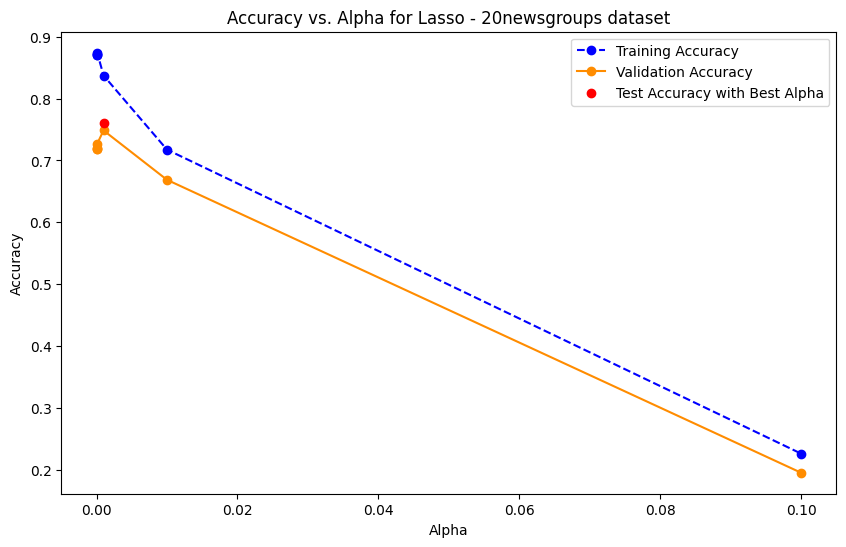

In [ ]:
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(x_news_matrix, y_news_matrix, test_size = 0.33, random_state=42, shuffle=True)

# Split the training data further into validation data
X_train_lasso, X_valid_lasso, y_train_lasso, y_valid_lasso = train_test_split(X_train_lasso, y_train_lasso, test_size = 0.5, random_state=42, shuffle=True)


alphas = [1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 0.01, 0.1]

train_accs = {}
val_accs = {}

for alpha in alphas:
  lasso_model = Lasso(alpha=alpha)
  lasso_model.fit(X_train_lasso, y_train_lasso)

  train_p = lasso_model.predict(X_train_lasso)
  train_score = evaluate(train_p, y_train_lasso)
  train_accs[alpha] = train_score

  validation_p = lasso_model.predict(X_valid_lasso)
  validation_score = evaluate(validation_p, y_valid_lasso)
  val_accs[alpha] = validation_score


best_alpha = max(val_accs, key = val_accs.get)

test_lasso = Lasso(alpha=best_alpha)
test_lasso.fit(X_train_lasso, y_train_lasso)
test_p = test_lasso.predict(X_test_lasso)

test_accuracy = evaluate(test_p, y_test_lasso)
print("Best alpha = ", best_alpha, "Test set score:", test_accuracy)





plt.figure(figsize=(10, 6))
plt.plot(list(train_accs.keys()), list(train_accs.values()), marker='o', linestyle='--', color='blue', label='Training Accuracy')
plt.plot(list(train_accs.keys()), list(val_accs.values()), marker='o', color='darkorange', label='Validation Accuracy')
plt.scatter(best_alpha, test_accuracy, color='red', label='Test Accuracy with Best Alpha', zorder=5)
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Alpha for Lasso - 20newsgroups dataset')
plt.xlabel('Alpha')
#plt.xticks(range(0, 1))
#plt.grid(True)
plt.show()


# Ridge Regression

Test on 20newsgroups dataset

Best alpha =  10 Test set score: 0.7611630321910696


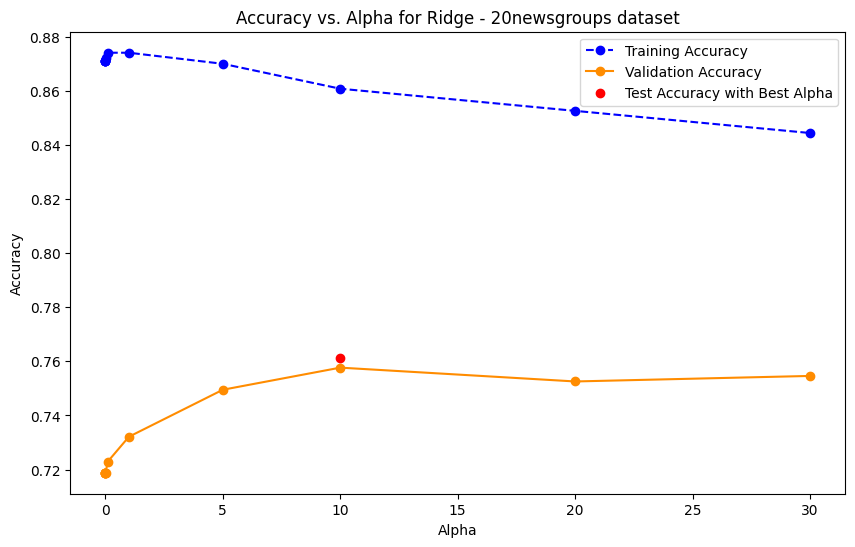

In [ ]:
X_train_ridge, X_test_ridge, y_train_ridge, y_test_ridge = train_test_split(x_news_matrix, y_news_matrix, test_size = 0.33, random_state=42, shuffle=True)

# Split the training data further into validation data
X_train_ridge, X_valid_ridge, y_train_ridge, y_valid_ridge = train_test_split(X_train_ridge, y_train_ridge, test_size = 0.5, random_state=42, shuffle=True)


alphas = [1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 5, 10, 20, 30]

train_accs = {}
val_accs = {}

for alpha in alphas:
  ridge_model = Ridge(alpha=alpha)
  ridge_model.fit(X_train_ridge, y_train_ridge)

  train_p = ridge_model.predict(X_train_ridge)
  train_score = evaluate(train_p, y_train_ridge)
  train_accs[alpha] = train_score

  validation_p = ridge_model.predict(X_valid_ridge)
  validation_score = evaluate(validation_p, y_valid_ridge)
  val_accs[alpha] = validation_score


best_alpha = max(val_accs, key = val_accs.get)

test_ridge = Ridge(alpha=best_alpha)
test_ridge.fit(X_train_ridge, y_train_ridge)
test_p = test_ridge.predict(X_test_ridge)

test_accuracy = evaluate(test_p, y_test_ridge)
print("Best alpha = ", best_alpha, "Test set score:", test_accuracy)





plt.figure(figsize=(10, 6))
plt.plot(list(train_accs.keys()), list(train_accs.values()), marker='o', linestyle='--', color='blue', label='Training Accuracy')
plt.plot(list(train_accs.keys()), list(val_accs.values()), marker='o', color='darkorange', label='Validation Accuracy')
plt.scatter(best_alpha, test_accuracy, color='red', label='Test Accuracy with Best Alpha', zorder=5)
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Alpha for Ridge - 20newsgroups dataset')
plt.xlabel('Alpha')
#plt.grid(True)
plt.show()